Copyright 2023 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

## Setup

In [1]:
from ast import literal_eval
import functools
import json
import os
import random
import wget


# Scienfitic packages
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
torch.set_grad_enabled(False)
tqdm.pandas()

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="notebook", 
        rc={"font.size":16,
            "axes.titlesize":16,
            "axes.labelsize":16,
            "xtick.labelsize": 16.0,
            "ytick.labelsize": 16.0,
            "legend.fontsize": 16.0})
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style='whitegrid')

# Utilities
from utils import (
    ModelAndTokenizer,
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_from_input,
)

# List of stopwords from NLTK, needed only for the attributes rate evaluation.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords0_ = stopwords.words('english')
stopwords0_ = {word: "" for word in stopwords0_}

/share/u/can/miniconda3/envs/attn_knockout_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /share/u/can/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
if not os.path.exists("known_1000.json"):
    wget.download("https://rome.baulab.info/data/dsets/known_1000.json")
knowns_df = pd.read_json("known_1000.json")

In [2]:
# Get CounterFact data for GPT2-xl, from the ROME repository.
wget.download("https://rome.baulab.info/data/dsets/known_1000.json")
knowns_df = pd.read_json("known_1000.json")


# Load GPT2-xl from Huggingface.
model_name = "gpt2-xl"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=None,
)
mt.model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=4800, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=1600)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6400, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=6400)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

## Methods

In [3]:
def _split_heads(tensor, num_heads, attn_head_size):
    new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
    tensor = tensor.view(new_shape)
    return tensor.permute(1, 0, 2)  # (head, seq_length, head_features)

def _merge_heads(tensor, model):
    num_heads = model.config.n_head
    attn_head_size = model.config.n_embd // model.config.n_head
    
    tensor = tensor.permute(1, 0, 2).contiguous()
    new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
    return tensor.view(new_shape)


def set_act_get_hooks(model, tok_index, attn=False, attn_out=False, mlp=False, mlp_coef=False):
    """
    Only works on GPT2
    """
    # Make sure that these are not set to True at the same time 
    #  so we don't put two different hooks on the same module.  
    assert not (attn is True and attn_out is True)
    
    for attr in ["activations_"]:
        if not hasattr(model, attr):
            setattr(model, attr, {})

    def get_activation(name):
        def hook(module, input, output):
            if "attn" in name:
                if "c_attn" in name:
                    # output.shape: batch_size, seq_len, 3 * hidden_dim
                    _, _, attn_value = output[0].split(model.config.n_embd, dim=1)
                    attn_value = _split_heads(attn_value,
                                              model.config.n_head, 
                                              model.config.n_embd // model.config.n_head)
                    model.activations_[name] = attn_value.detach()
                elif "attn_weights" in name:
                    assert len(output) == 3
                    attn_weights = output[2]  # (batch_size, num_heads, from_sequence_length, to_sequence_length)
                    # the last dimension is a distribution obtained from softmax
                    model.activations_[name] = attn_weights[0][:, tok_index, :].detach()
                else:
                    model.activations_[name] = output[0][:, tok_index].detach()
            elif "m_coef" in name:
                # num_tokens = list(input[0].size())[1]  # (batch, sequence, hidden_state)
                model.activations_[name] = input[0][:, tok_index].detach()
            elif "m_out" in name:
                model.activations_[name] = output[0][tok_index].detach()
        
        return hook

    hooks = []
    for i in range(model.config.n_layer):
        if attn is True:
            hooks.append(model.transformer.h[i].attn.c_attn.register_forward_hook(get_activation(f"c_attn_value_{i}")))
            hooks.append(model.transformer.h[i].attn.register_forward_hook(get_activation(f"attn_weights_{i}")))
        if attn_out is True:
            hooks.append(model.transformer.h[i].attn.register_forward_hook(get_activation(f"attn_out_{i}")))
        if mlp_coef is True:
            hooks.append(model.transformer.h[i].mlp.c_proj.register_forward_hook(get_activation("m_coef_" + str(i))))
        if mlp is True:
            hooks.append(model.transformer.h[i].mlp.register_forward_hook(get_activation("m_out_" + str(i))))
            
    return hooks


# To block attention edges, we zero-out entries in the attention mask.
# To do this, we add a wrapper around the attention module, because 
# the mask is passed as an additional argument, which could not be fetched 
# with standard hooks before pytorch 2.0.  
def set_block_attn_hooks(model, from_to_index_per_layer, opposite=False):
    """
    Only works on GPT2
    """
    def wrap_attn_forward(forward_fn, model_, from_to_index_, opposite_):
        @functools.wraps(forward_fn)
        def wrapper_fn(*args, **kwargs):
            new_args = []
            new_kwargs = {}
            for arg in args:
                new_args.append(arg)
            for (k, v) in kwargs.items():
                new_kwargs[k] = v

            hs = args[0]
            num_tokens = list(hs[0].size())[0]
            num_heads = model_.config.num_attention_heads
            
            if opposite_:
                attn_mask = torch.tril(torch.zeros((num_tokens, num_tokens), dtype=torch.uint8))
                for s, t in from_to_index_:
                    attn_mask[s, t] = 1
            else:
                attn_mask = torch.tril(torch.ones((num_tokens, num_tokens), dtype=torch.uint8))
                for s, t in from_to_index_:
                    attn_mask[s, t] = 0
            attn_mask = attn_mask.repeat(1, num_heads, 1, 1)
            
            attn_mask = attn_mask.to(dtype=model_.dtype)  # fp16 compatibility
            attn_mask = (1.0 - attn_mask) * torch.finfo(model_.dtype).min
            attn_mask = attn_mask.to(hs.device)

            new_kwargs["attention_mask"] = attn_mask
            
            return forward_fn(*new_args, **new_kwargs)

        return wrapper_fn
    
    hooks = []
    for i in from_to_index_per_layer.keys():
        hook = model.transformer.h[i].attn.forward
        model.transformer.h[i].attn.forward = wrap_attn_forward(model.transformer.h[i].attn.forward,
                                                                model, from_to_index_per_layer[i], opposite)
        hooks.append((i, hook))
    
    return hooks


def set_get_attn_proj_hooks(model, tok_index):
    """
    Only works on GPT2
    """
    for attr in ["projs_"]:
        if not hasattr(model, attr):
            setattr(model, attr, {})

    def get_projection(name, E):
        def hook(module, input, output):
            attn_out = output[0][:, tok_index]
            probs, preds = torch.max(
                torch.softmax(attn_out.matmul(E.T), dim=-1), 
                dim=-1
            )
            model.projs_[f"{name}_probs"] = probs.cpu().numpy()
            model.projs_[f"{name}_preds"] = preds.cpu().numpy()
            
        return hook

    E = model.get_input_embeddings().weight.detach()
    hooks = []
    for i in range(model.config.n_layer):
        hooks.append(model.transformer.h[i].attn.register_forward_hook(get_projection(f"attn_proj_{i}", E)))
            
    return hooks


def set_block_mlp_hooks(model, values_per_layer, coef_value=0):
    
    def change_values(values, coef_val):
        def hook(module, input, output):
            output[:, :, values] = coef_val

        return hook

    hooks = []
    for layer in range(model.config.n_layer):
        if layer in values_per_layer:
            values = values_per_layer[layer]
        else:
            values = []
        hooks.append(model.transformer.h[layer].mlp.c_fc.register_forward_hook(
            change_values(values, coef_value)
        ))

    return hooks


def set_proj_hooks(model):
    for attr in ["projs_"]:
        if not hasattr(model, attr):
            setattr(model, attr, {})

    def get_projection(name, E):
        def hook(module, input, output):
            num_tokens = list(input[0].size())[1]  #(batch, sequence, hidden_state)
            if name == f"layer_residual_{final_layer}":
                hs = output
            else:
                hs = input[0]
            probs, preds = torch.max(
                torch.softmax(hs.matmul(E.T), dim=-1), 
                dim=-1
            )
            model.projs_[f"{name}_preds"] = preds.cpu().numpy()
            model.projs_[f"{name}_probs"] = probs.cpu().numpy()
        return hook

    E = model.get_input_embeddings().weight.detach()
    final_layer = model.config.n_layer-1
    
    hooks = []
    for i in range(model.config.n_layer-1):
        hooks.append(model.transformer.h[i].register_forward_hook(
            get_projection(f"layer_residual_{i}", E)
        ))
    hooks.append(model.transformer.ln_f.register_forward_hook(
        get_projection(f"layer_residual_{final_layer}", E)
    ))

    return hooks


def set_hs_patch_hooks(model, hs_patch_config, patch_input=False):
    
    def patch_hs(name, position_hs, patch_input):
        
        def pre_hook(module, input):
            for position_, hs_ in position_hs:
                # (batch, sequence, hidden_state)
                input[0][0, position_] = hs_
        
        def post_hook(module, input, output):
            for position_, hs_ in position_hs:
                # (batch, sequence, hidden_state)
                output[0][0, position_] = hs_
        
        if patch_input:
            return pre_hook
        else:
            return post_hook

    hooks = []
    for i in hs_patch_config:
        if patch_input:
            hooks.append(model.transformer.h[i].register_forward_pre_hook(
                patch_hs(f"patch_hs_{i}", hs_patch_config[i], patch_input)
            ))
        else:
            hooks.append(model.transformer.h[i].register_forward_hook(
                patch_hs(f"patch_hs_{i}", hs_patch_config[i], patch_input)
            ))

    return hooks
    

# Always remove your hooks, otherwise things will get messy.
def remove_hooks(hooks):
    for hook in hooks:
        hook.remove()

def remove_wrapper(model, hooks):
    for i, hook in hooks:
        model.transformer.h[i].attn.forward = hook

In [4]:
def trace_with_attn_block(
    model,
    inp,
    from_to_index_per_layer,   # A list of (source index, target index) to block
    answers_t
):
    with torch.no_grad():
        # set hooks
        block_attn_hooks = set_block_attn_hooks(model, from_to_index_per_layer)
        
        # get prediction
        outputs_exp = model(**inp)
        
        # remove hooks
        remove_wrapper(model, block_attn_hooks)
    
    probs = torch.softmax(outputs_exp.logits[0, -1, :], dim=0)[answers_t]
    
    return probs


def trace_with_proj(model, inp):
    with torch.no_grad():
        # set hooks
        hooks = set_proj_hooks(model)
        
        # get prediction
        answer_t, base_score = [d[0] for d in predict_from_input(model, inp)]
        
        # remove hooks
        remove_hooks(hooks)
        
    projs = model.projs_
    
    return answer_t, base_score, projs


In [5]:
def intervene_on_info_flow(
    mt, prompt, source=None, kind="single", window=10, positions=None
):
    inp = make_inputs(mt.tokenizer, [prompt])
    answer_t, base_score, projs = trace_with_proj(mt.model, inp)
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    
    ntoks = inp["input_ids"].shape[1]
    if source is None:
        source_ = ntoks-1
    else:
        source_ = source
        
    if positions is None:
        positions = list(range(ntoks))
        
    table = []
    for tnum in positions:
        row = []
        for layer in range(mt.num_layers):
            if kind == "single":
                block_config = {layer: [(source_, tnum)]}
                r = trace_with_attn_block(
                    mt.model, inp, block_config, answer_t
                )
            elif kind == "window":
                layerlist = [
                    l for l in range(
                        max(0, layer - window // 2), min(mt.num_layers, layer - (-window // 2))
                    )
                ]
                block_config = {
                    l: [(source_, tnum)]
                    for l in layerlist
                }
                r = trace_with_attn_block(
                    mt.model, inp, block_config, answer_t
                )
            else:
                raise NotImplementedError
            row.append(r)
        table.append(torch.stack(row))
    differences = torch.stack(table)
    differences = differences.detach().cpu()
    
    low_score = differences.min()
    
    source_probs = [projs[f"layer_residual_{l}_probs"][0][source_] for l in range(mt.num_layers)]
    source_preds = decode_tokens(mt.tokenizer, 
                                 [projs[f"layer_residual_{l}_preds"][0][source_] for l in range(mt.num_layers)])
    
    return dict(
        scores=differences,
        source_probs=source_probs,
        source_preds=source_preds,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        answer=answer,
        source=source_,
        window=window,
        kind="",
    )



In [6]:
def plot_info_flow(
    mt,
    prompt,
    source=None,
    kind="single",
    window=10,
    set_lims=True,
    show_proj=True,
    savepdf=None,
):
    result = intervene_on_info_flow(mt, prompt, source, kind, window)
    
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    window = result.get("window", 10)
    source = result['source']
    labels = list(result["input_tokens"])
    labels[source] = labels[source] + "*"

    size_height = len(labels) * 0.3
    fig, ax = plt.subplots(figsize=(7, size_height), dpi=150)
    if set_lims:
        h = ax.pcolor(
            differences,
            cmap="Purples_r",
            vmin=0.0,
            vmax=1.0
        )
    else:
        h = ax.pcolor(
            differences,
            cmap="Purples_r",
        )
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)

    if show_proj:
        for x in range(mt.num_layers):
            plt.text(
                x + 0.5, source + 0.5, 
                f'{result["source_preds"][x]} {round(100.0 * result["source_probs"][x], 1)}',
                horizontalalignment='center', verticalalignment='center', rotation=90, fontsize=4,
            )

    cb = plt.colorbar(h)
    ax.set_title(
        f"Intervening on flow to: {result['input_tokens'][source]}\nwindow: {window}, base probability: {round(result['high_score'].cpu().numpy().item(), 4)}",
        fontsize=10
        )
    if answer is not None:
        cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()
    
    return result


## Information Flow Analysis

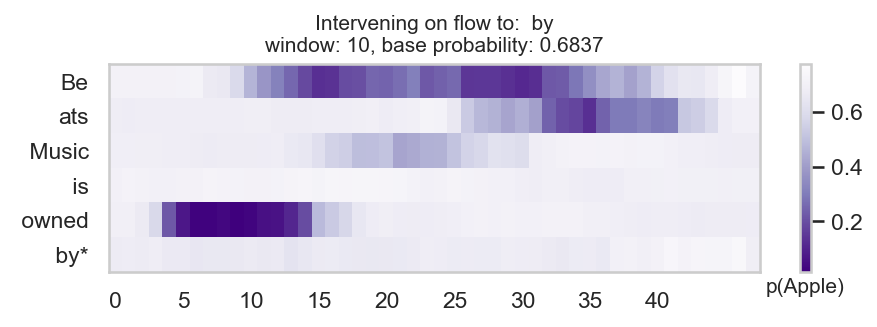

In [7]:
# Single-example interventions.

prompt = "Beats Music is owned by"    
inp = make_inputs(mt.tokenizer, [prompt])
results = plot_info_flow(mt, prompt, source=None, kind="window", window=10, 
                         set_lims=False, show_proj=False,
                         # savepdf=f"figs/{prompt}.pdf"
                        )

1209it [49:23,  2.45s/it]


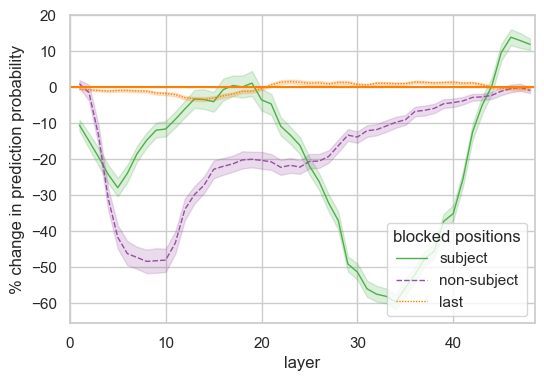

In [8]:
# Information flow analysis

window = 9

# Run attention knockouts
results = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject

    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]

    answer_t, base_score, projs = trace_with_proj(mt.model, inp)
    base_score = base_score.cpu().item()
    [answer] = decode_tokens(mt.tokenizer, [answer_t])

    ntoks = inp["input_ids"].shape[1]
    source_ = ntoks-1

    for block_ids, block_desc in [
        ([x for x in e_range], "subject"),
        ([x for x in range(ntoks-1) if x not in e_range], "non-subject"),
        ([source_], "last"),
    ]:
        for layer in range(mt.num_layers):
            layerlist = [
                l for l in range(
                    max(0, layer - window // 2), min(mt.num_layers, layer - (-window // 2))
                )
            ]
            block_config = {
                l: [(source_, stok) for stok in block_ids]
                for l in layerlist
            }
            r = trace_with_attn_block(
                mt.model, inp, block_config, answer_t
            )
            new_score = r.cpu().item()
            results.append({
                "prompt": prompt,
                "block_desc": block_desc,
                "layer": layer,
                "base_score": base_score,
                "new_score": new_score,
                "relative diff": (new_score - base_score) * 100.0 / base_score,
                "is_subject_position_zero": e_range[0] == 0
            })

tmp = pd.DataFrame.from_records(results)
tmp["layer_1"] = tmp.layer.apply(lambda x: x+1)


# Plot the results
plt.figure(figsize=(6,4))
ax = sns.lineplot(tmp, x="layer_1", y="relative diff", 
                  hue="block_desc",
                  style="block_desc",
                  dashes=True,
                  palette=palette[:3], linewidth=1)
ax.set_xlabel("layer")
ax.set_ylabel("% change in prediction probability")
ax.set_xlim(0, mt.num_layers+0.5)
sns.move_legend(ax, "lower right", title="blocked positions")
plt.axhline(y=0, color=palette[2], linestyle='-')
